# Gather insights from the experiments run on GCP

In [2]:
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt

## Read the experiments file

In [3]:
experiment_file = './resnet_36exp.pkl'
df = pd.read_pickle(experiment_file)

df.head()



,id,model_type,batch_size,epochs,dataset,lr,function_name,default_parallelism,static_parallelism,validate_every,k,goal_accuracy,validation_loss,accuracy,train_loss,parallelism,epoch_duration
0,03da5d25,example,128,1,cifar10,0.1,resnet,8,True,1,8,100,[1.9938284747208221],[26.41],[3.609585141763091],[8],[577.992817891]
1,231943ff,example,128,1,cifar10,0.1,resnet,32,True,1,8,100,[175.9012781457056],[10],[6.146889317873865],[32],[255.3115073]
2,2aaa8a3d,example,32,1,cifar10,0.1,resnet,32,True,1,64,100,[6.456673442365262],[10],[8.465176700492991],[32],[628.306893289]
3,2ec1758f,example,64,1,cifar10,0.1,resnet,32,True,1,16,100,[4.153203514730855],[10],[5.782667923899782],[32],[414.973165487]
4,350e0676,example,64,1,cifar10,0.1,resnet,32,True,1,64,100,[6.385458897633158],[10],[7.8308387949814415],[32],[415.313563337]


### Create new columns for representation

- Final accuracy
- Total time taken
- Parallelism

In [4]:
# Set the acc to the final accuracy
df['acc'] = df.accuracy.map(lambda a: a[-1])

# Set the time to the sum of the epoch durations
df['time'] = df.epoch_duration.map(sum)

# Set the parallelism to the first since it is constant
df.parallelism = df.parallelism.map(lambda l:l[0])

# change -1 to inf so the order is right in the plot
df.k = df.k.map(lambda val: float('inf') if val == -1 else val)

df['global_batch'] = df.batch_size * df.parallelism



In [ ]:
from typing import List

def accum_time(durations: List[float]):
    # print('before', durations)
    for i in range(1, len(durations)):
        durations[i] += durations[i-1]
    return durations
        
df.epoch_duration.map(lambda durs: accum_time(durs))
        

### Plot the Correlations between the K, Batch and Parallelism with time and accuracy

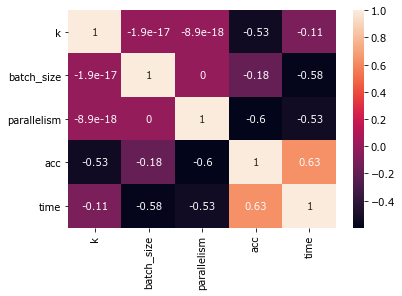

In [14]:
sns.set_palette('Set1')

corr = df[['k', 'batch_size', 'parallelism', 'acc', 'time']].corr()
sns.heatmap(corr,
            annot=True,
)

plt.savefig('./figures/resnet34/heat.png', dpi=300)


In [48]:
df.sort_values('time')


,id,model_type,batch_size,epochs,dataset,lr,function_name,default_parallelism,static_parallelism,validate_every,k,goal_accuracy,validation_loss,accuracy,train_loss,parallelism,epoch_duration,acc,time,global_batch
8,4cf3c3d1,example,128,1,cifar10,0.1,resnet,32,True,1,64,100,[3.2593925180314463],[10],[6.321312318627649],32,[231.404655465],10.00,231.404655,4096
30,e8774533,example,128,1,cifar10,0.1,resnet,32,True,1,16,100,[4.1188574923744685],[10],[6.713552589743182],32,[235.325811442],10.00,235.325811,4096
1,231943ff,example,128,1,cifar10,0.1,resnet,32,True,1,8,100,[175.9012781457056],[10],[6.146889317873865],32,[255.3115073],10.00,255.311507,4096
22,a93afb72,example,128,1,cifar10,0.1,resnet,16,True,1,64,100,[4.762643234639228],[10],[5.533098703573147],16,[281.368999286],10.00,281.368999,2048
33,f3c9c787,example,128,1,cifar10,0.1,resnet,16,True,1,16,100,[2.6491925927657114],[10],[4.912968591838661],16,[297.962827092],10.00,297.962827,2048
20,a306cc05,example,128,1,cifar10,0.1,resnet,16,True,1,8,100,[2.505303313460531],[12.04],[4.690482895355672],16,[340.314645023],12.04,340.314645,2048
29,d891b5c4,example,64,1,cifar10,0.1,resnet,32,True,1,8,100,[3.5920156475844656],[10],[6.230884659104049],32,[396.080938403],10.00,396.080938,2048
28,d83ce6a3,example,64,1,cifar10,0.1,resnet,8,True,1,64,100,[2.348529586366787],[10],[4.230737259628919],8,[400.757454297],10.00,400.757454,512
3,2ec1758f,example,64,1,cifar10,0.1,resnet,32,True,1,16,100,[4.153203514730855],[10],[5.782667923899782],32,[414.973165487],10.00,414.973165,2048
4,350e0676,example,64,1,cifar10,0.1,resnet,32,True,1,64,100,[6.385458897633158],[10],[7.8308387949814415],32,[415.313563337],10.00,415.313563,2048


### Get the max accuracies and times and check the parameters used

In [52]:
# get the max accuracies
df[['k', 'parallelism', 'acc','batch_size','time']].sort_values(by='time', ascending=True)

,k,parallelism,acc,batch_size,time
8,64,32,10.00,128,231.404655
30,16,32,10.00,128,235.325811
1,8,32,10.00,128,255.311507
22,64,16,10.00,128,281.368999
33,16,16,10.00,128,297.962827
20,8,16,12.04,128,340.314645
29,8,32,10.00,64,396.080938
28,64,8,10.00,64,400.757454
3,16,32,10.00,64,414.973165
4,64,32,10.00,64,415.313563


## Which of the parameter combinations offer a better bang for the buck

In [47]:
m = df.loc[df.acc>10].groupby(['k', 'global_batch']).mean()
m['rate'] = m['acc']/m['time']
m.sort_values('rate', ascending=False)[['batch_size','acc', 'time', 'rate']]

batch_size        acc         time      rate
k  global_batch                                              
8  512            74.666667  31.546667   709.613795  0.044456
16 256            48.000000  30.645000   715.973987  0.042802
   512            74.666667  26.650000   650.737277  0.040954
8  256            48.000000  32.605000   867.619565  0.037580
   2048          128.000000  12.040000   340.314645  0.035379
   1024           74.666667  20.266667   586.269787  0.034569
16 128            32.000000  27.210000   816.765409  0.033314
8  128            32.000000  38.130000  1146.221605  0.033266
16 1024           96.000000  14.700000   443.026322  0.033181
64 128            32.000000  19.930000  1032.666816  0.019300
   256            48.000000  13.125000   794.623481  0.016517

## Calculate TTA with different accuracies



In [ ]:
# Calculate time to accuracy for different accuracies
def tta(acc:int, df: pd.DataFrame):

    res = []
    for _, row in df.iterrows():
        done = False
        dur, accuracy = row.epoch_duration, row.accuracy
        for idx, (t, a) in enumerate(zip(dur, accuracy[:len(dur)])):
            if a >= acc:
                res.append(t)
                done = True
                break

        if not done:
            res.append(np.nan)

    return res

In [ ]:

df['tta_95'] = tta(95, df)



df.sort_values('tta_95')


In [ ]:
sns.barplot(x='k', y='tta_95', data=df)

In [ ]:
df.head(10)
sns.set_palette('muted')

### Plot the distributions of time and accuracy as a function of K, Batch and parallelism

#### Plot the accuracy as a factor

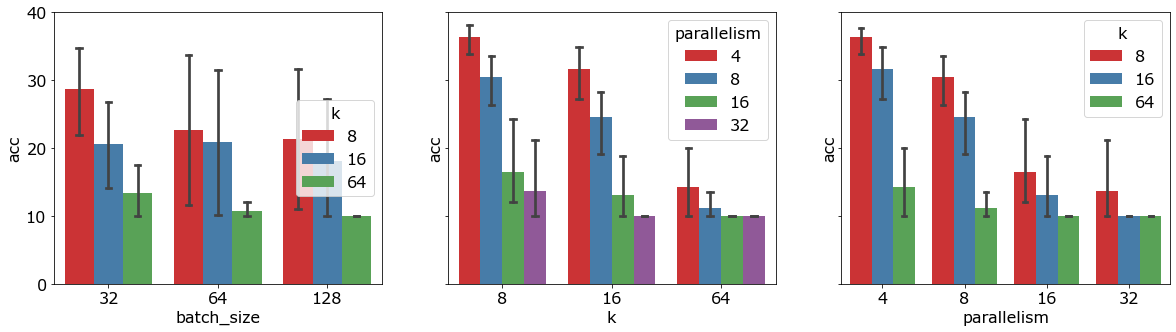

In [44]:
f, ax = plt.subplots(1, 3, sharey=True, figsize=(20, 5))
sns.barplot(x='batch_size', y='acc', hue='k', data=df, ax=ax[0], capsize=.05)
sns.barplot(x='k', y='acc', data=df, ax=ax[1], capsize=.05, hue='parallelism')
sns.barplot(x='parallelism', y='acc', data=df, hue='k' ,ax=ax[2] ,capsize=.05)


plt.savefig('./figures/resnet34/accuracy.png', dpi=300)

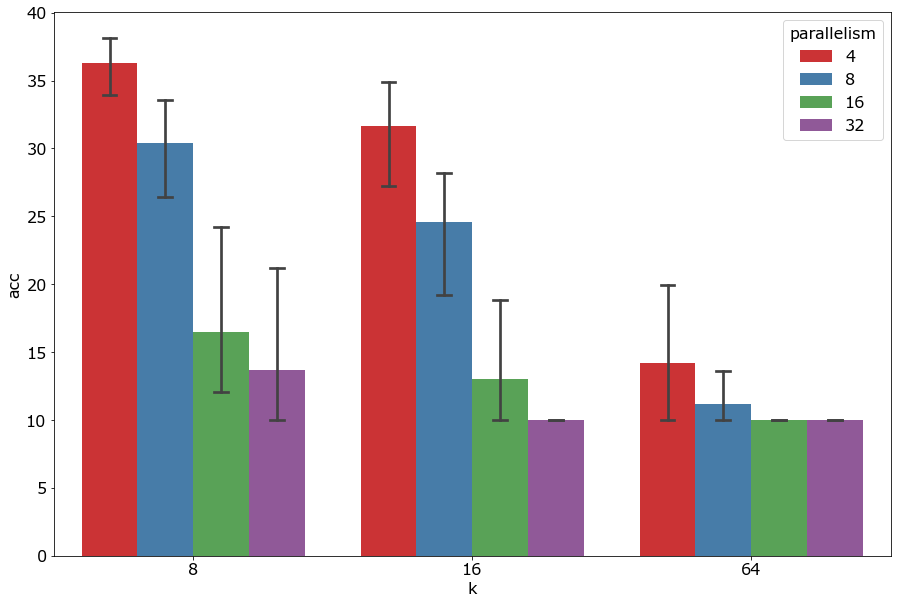

In [42]:
plt.rc('font', size=16)
plt.figure(figsize=(15,10))
sns.barplot(x='k', y='acc', data=df, capsize=.05, hue='parallelism')

plt.savefig('./figures/resnet34/acc_per_k_and_parallelism.png', dpi=300)

#### Plot the time as a factor

In [ ]:
f, ax = plt.subplots(1, 3, sharey=True, figsize=(20, 5))
sns.barplot(x='batch_size', y='time', hue='k', data=df, ax=ax[0])
sns.barplot(x='k', y='time', data=df, ax=ax[1])
sns.barplot(x='parallelism', y='time', data=df, ax=ax[2], hue='k')

plt.savefig('./figures/resnet34/time.png', dpi=300)

In [ ]:
plt.rc('font', size=16)
f, ax = plt.subplots(1, 3, figsize=(20,8), sharey=True)
sns.barplot(x='k', y='time', data=df.loc[df.batch_size==32], capsize=.05, hue='parallelism', ax=ax[0])
sns.barplot(x='k', y='time', data=df.loc[df.batch_size==64], capsize=.05, hue='parallelism', ax=ax[1])
sns.barplot(x='k', y='time', data=df.loc[df.batch_size==128], capsize=.05, hue='parallelism', ax=ax[2])

plt.savefig('./figures/resnet34/time_per_all.png', dpi=300)

In [ ]:
plt.figure(figsize=(15,10))
sns.scatterplot('time', 'acc', data=df.loc[df.acc>10], hue='k', palette='deep', size='batch_size', style='parallelism', sizes=(50, 500))
plt.title('Balance between accuracy and time based on configuration')
plt.savefig('./figures/resnet34//balance.png', dpi=300)

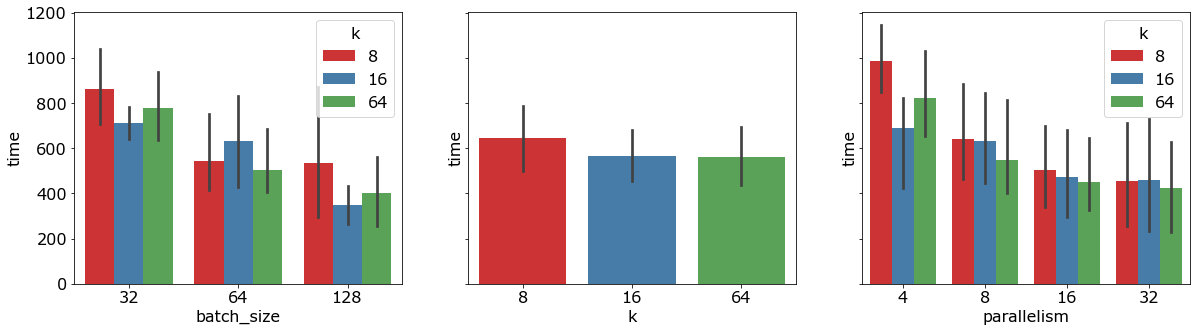

In [43]:
## Plot the Accuracy progression varying K and parallelism

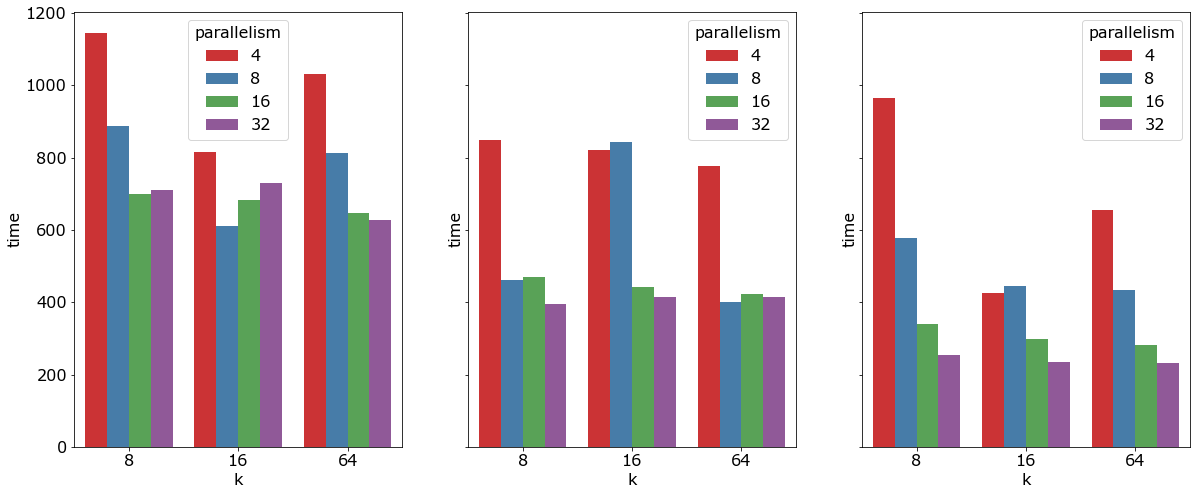

In [41]:
plt.rc('font', size=16)
f, ax = plt.subplots(1, 3, figsize=(20,8), sharey=True)
sns.barplot(x='k', y='time', data=df.loc[df.batch_size==32], capsize=.05, hue='parallelism', ax=ax[0])
sns.barplot(x='k', y='time', data=df.loc[df.batch_size==64], capsize=.05, hue='parallelism', ax=ax[1])
sns.barplot(x='k', y='time', data=df.loc[df.batch_size==128], capsize=.05, hue='parallelism', ax=ax[2])

plt.savefig('./figures/resnet34/time_per_all.png', dpi=300)

c:\users\diego\cs\qpe\venv\lib\site-packages\seaborn\_decorators.py:43: FutureWarning: Pass the following variables as keyword args: x, y. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  FutureWarning


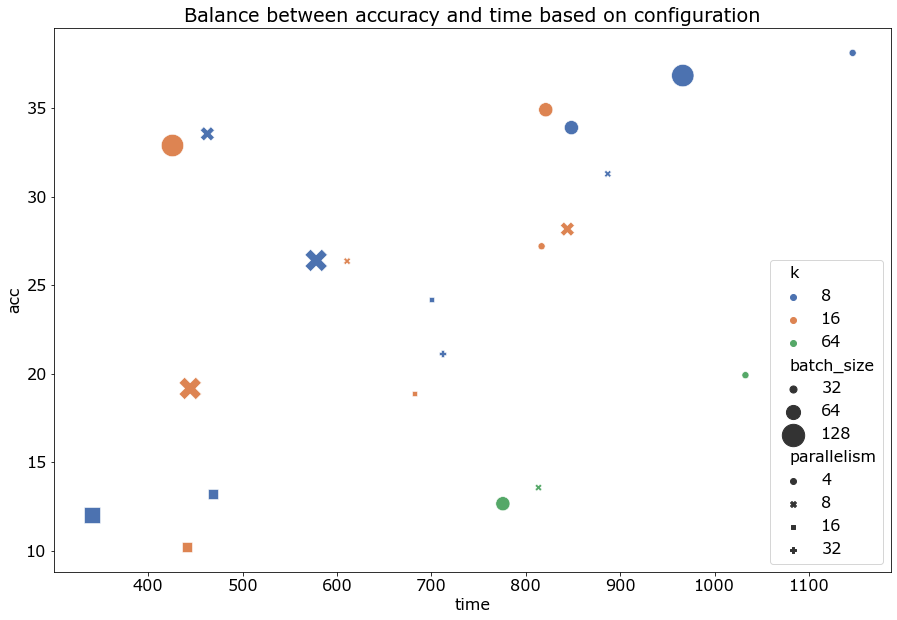

In [68]:
plt.figure(figsize=(15,10))
sns.scatterplot('time', 'acc', data=df.loc[df.acc>10], hue='k', palette='deep', size='batch_size', style='parallelism', sizes=(50, 500))
plt.title('Balance between accuracy and time based on configuration')
plt.savefig('./figures/resnet34//balance.png', dpi=300)

## Plot the Accuracy progression varying K and parallelism

#### Keep K and Batch set, vary parallelism

In [ ]:
# Plot the validation lines of k=-1 and batch = 32 with different parallelism
def plot_loss_with_k_and_batch(k: int, batch:int, ax: plt.Axes = None):
    d = df.loc[(df.k==k) & (df.batch_size==batch)].sort_values(by='parallelism', ascending=False)

    plt.rc('font', size=13)
    if ax is None:
        f = plt.figure(figsize=(10, 5))
        for _, row in d.iterrows():
#             print(row.accuracy)
            plt.plot(range(1,6), row.accuracy[:-1] if len(row.accuracy) == 6 else row.accuracy, label=str(row.parallelism))
        plt.xlabel('Epoch')
        plt.ylabel('Accuracy (%)')
        plt.title(f'Accuracy evolution with LeNet (batch={batch}, k={k})')
        plt.legend(title='parallelism', bbox_to_anchor=(1.05, 0.8))
        
    else:
        for _, row in d.iterrows():
#             print(row.accuracy)
            ax.plot(range(1,6), row.accuracy[:-1] if len(row.accuracy) == 6 else row.accuracy, label=str(row.parallelism))
        ax.set_xlabel('Epoch')
        ax.set_ylabel('Accuracy (%)')
        ax.set_title(f'Batch={batch}, k={k}')
        ax.legend(title='parallelism')
        

f, axes = plt.subplots(nrows=3, ncols=3, figsize=(20, 15), sharex=True)

plt.suptitle('Behavior of K, Parallelism and Batch in Accuracy')

plot_loss_with_k_and_batch(k=8, batch=32, ax=axes[0][0])
plot_loss_with_k_and_batch(k=16, batch=32, ax=axes[0][1])   
plot_loss_with_k_and_batch(k=64, batch=32, ax=axes[0][2])
    
plot_loss_with_k_and_batch(k=8, batch=64, ax=axes[1][0])
plot_loss_with_k_and_batch(k=16, batch=64, ax=axes[1][1])   
plot_loss_with_k_and_batch(k=64, batch=64, ax=axes[1][2])

plot_loss_with_k_and_batch(k=8, batch=128, ax=axes[2][0])
plot_loss_with_k_and_batch(k=16, batch=128, ax=axes[2][1])   
plot_loss_with_k_and_batch(k=64, batch=128, ax=axes[2][2])


# plt.savefig('./figures/accuracy_study.png', dpi=300)


#### Keep Parallelism and batch set, vary K

#### Keep K and Batch set, vary parallelism

In [ ]:
# Plot the validation lines of k=-1 and batch = 32 with different parallelism
def plot_loss_with_k_and_batch(k: int, batch:int, ax: plt.Axes = None):
    d = df.loc[(df.k==k) & (df.batch_size==batch)].sort_values(by='parallelism', ascending=False)

    plt.rc('font', size=13)
    if ax is None:
        f = plt.figure(figsize=(10, 5))
        for _, row in d.iterrows():
#             print(row.accuracy)
            plt.plot(range(1,6), row.accuracy[:-1] if len(row.accuracy) == 6 else row.accuracy, label=str(row.parallelism))
        plt.xlabel('Epoch')
        plt.ylabel('Accuracy (%)')
        plt.title(f'Accuracy evolution with LeNet (batch={batch}, k={k})')
        plt.legend(title='parallelism', bbox_to_anchor=(1.05, 0.8))
        
    else:
        for _, row in d.iterrows():
#             print(row.accuracy)
            ax.plot(range(1,6), row.accuracy[:-1] if len(row.accuracy) == 6 else row.accuracy, label=str(row.parallelism))
        ax.set_xlabel('Epoch')
        ax.set_ylabel('Accuracy (%)')
        ax.set_title(f'Batch={batch}, k={k}')
        ax.legend(title='parallelism')
        

f, axes = plt.subplots(nrows=3, ncols=3, figsize=(20, 15), sharex=True)

plt.suptitle('Behavior of K, Parallelism and Batch in Accuracy')

plot_loss_with_k_and_batch(k=8, batch=32, ax=axes[0][0])
plot_loss_with_k_and_batch(k=16, batch=32, ax=axes[0][1])   
plot_loss_with_k_and_batch(k=64, batch=32, ax=axes[0][2])
    
plot_loss_with_k_and_batch(k=8, batch=64, ax=axes[1][0])
plot_loss_with_k_and_batch(k=16, batch=64, ax=axes[1][1])   
plot_loss_with_k_and_batch(k=64, batch=64, ax=axes[1][2])

plot_loss_with_k_and_batch(k=8, batch=128, ax=axes[2][0])
plot_loss_with_k_and_batch(k=16, batch=128, ax=axes[2][1])   
plot_loss_with_k_and_batch(k=64, batch=128, ax=axes[2][2])


# plt.savefig('./figures/accuracy_study.png', dpi=300)


#### Keep Parallelism and batch set, vary K

In [ ]:
# Plot the validation lines of k=-1 and batch = 32 with different parallelism
def plot_loss_with_parallelism_and_batch(p: int, batch:int, ax: plt.Axes = None):
    d = df.loc[(df.parallelism==p) & (df.batch_size==batch)].sort_values(by='k', ascending=False)
    
    approx_k = (60000/p)/batch

    plt.rc('font', size=16)
    if ax is None:
        f = plt.figure(figsize=(10, 5))
        for _, row in d.iterrows():
#             print(row.accuracy)
            plt.plot(range(1,6), row.accuracy[:-1] if len(row.accuracy) == 6 else row.accuracy, label=str(row.k))
        plt.xlabel('Epoch')
        plt.ylabel('Accuracy (%)')
        plt.title(f'Accuracy evolution with LeNet (batch={batch}, k={k})')
        plt.legend(title='parallelism', bbox_to_anchor=(1.05, 0.8))
        
    else:
        for _, row in d.iterrows():
            label = str(row.k) if row.k != float('inf') else f'{row.k} ({int(approx_k)})'
            ax.plot(range(1,6), row.accuracy[:-1] if len(row.accuracy) == 6 else row.accuracy, label=label)
        ax.set_xlabel('Epoch')
        ax.set_ylabel('Accuracy (%)')
        ax.set_title(f'Batch={batch}, Parallelism={p}')
        ax.legend(title='k')
        

f, axes = plt.subplots(nrows=3, ncols=3, figsize=(30, 20), sharex=True)

plt.suptitle('Behavior of K, Parallelism and Batch in Accuracy')

plot_loss_with_parallelism_and_batch(p=2, batch=32, ax=axes[0][0])
plot_loss_with_parallelism_and_batch(p=4, batch=32, ax=axes[0][1])   
plot_loss_with_parallelism_and_batch(p=8, batch=32, ax=axes[0][2])

plot_loss_with_parallelism_and_batch(p=2, batch=64, ax=axes[1][0])
plot_loss_with_parallelism_and_batch(p=4, batch=64, ax=axes[1][1])   
plot_loss_with_parallelism_and_batch(p=8, batch=64, ax=axes[1][2])

plot_loss_with_parallelism_and_batch(p=2, batch=128, ax=axes[2][0])
plot_loss_with_parallelism_and_batch(p=4, batch=128, ax=axes[2][1])   
plot_loss_with_parallelism_and_batch(p=8, batch=128, ax=axes[2][2])


plt.savefig('./figures/accuracy_study_varying_k.png', dpi=300)

#### Plot 3d dependencies between K and parallelism on time and accuracy

In [ ]:
# f, ax = plt.subplots(1, 2, projection='3d')

f = plt.figure()
ax = f.add_subplot(1, 2, 1, projection='3d')

from scipy.interpolate import griddata
X, Y = np.meshgrid(df.k.map(lambda v: 500 if v == float('inf') else v), df.parallelism)
Z = griddata((df.k.map(lambda v: 500 if v == float('inf') else v),
              df.parallelism),
              df.acc, (X, Y), method='cubic')

ax.plot_surface(X, Y, Z, rstride=1, cstride=1, cmap='coolwarm',
                       linewidth=0, antialiased=False)


In [ ]:
d = df.loc[df.batch==64]